# Сегментация текста

Идея метода:
- разбиение текстов более 512 токенов на перекрывающиеся сегменты
- подача сегментов в модель трансформера
- объединение векторных представлений сегментов в одно представление всего текста
- приведение всех векторных представлений к одной размерности
- создание маски
- классификация данных

**Рабиение текстов на сегменты**

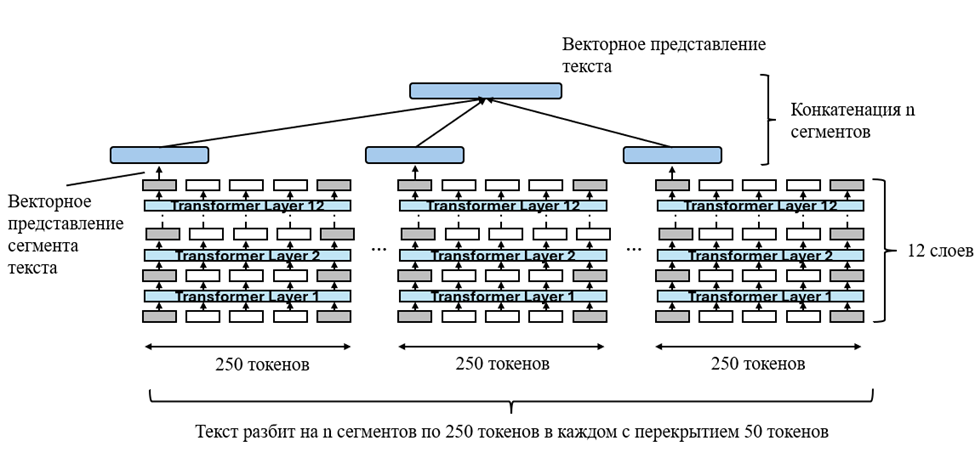

Важно отметить, что при обработке всего текста «слой внимания» имеет квадратичную сложность O(n2) в терминах длины последовательности n. Однако в данном подходе обрабатывается не вся последовательность, а ее часть – сегмент, длину которого можно регулировать, что приводит к уменьшению вычислительной сложности O(n*k), где k – размер сегмента.

**Приведение к одной размерности**

Возникает ограничение, связанное с разной длиной итоговых векторных представлений, поскольку тексты, в зависимости от длины, разбиваются на разное число сегментов. Это приводит к необходимости приведения векторных представлений к одной размерности, для этого проводится их заполнение до максимальной длины в корпусе. На выходе векторные представления являются двумерным вектором размерности - (размер батча, длина последовательности).

**Маска**

Создается маска для указания модели классификатора, где находятся реальные, а где специальные токены

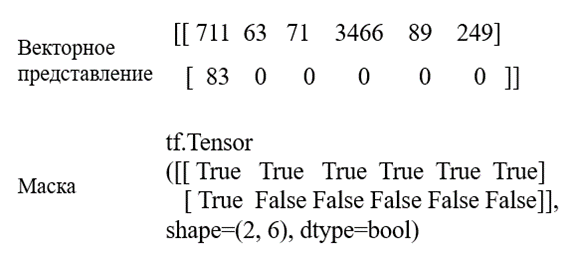

**Схема подхода**

В качестве модели классификатора рассмотрена модель LSTM. Рекуррентные нейронные сети известны тем, что способны улавливать долгосрочные зависимости в последовательностях, что является важным преимуществом при работе с векторными представлениями всего текста.



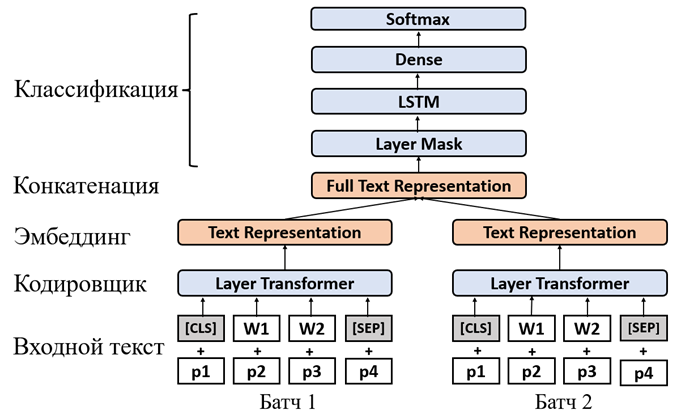

## Загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

## Загрузка и предобработка данных

В качестве набора данных используются данные медицинских статей, полученные с платформы Arxiv.org


[Ссылка](https://www.kaggle.com/datasets/ekaterinamayatskaya/medical-articles)

In [ ]:
import pickle

In [ ]:
df= pd.read_pickle('df_new_10.pkl')

In [ ]:
df =  df[['Абстракт', 'Метка']]

In [ ]:
df = df.rename(columns={'Абстракт': 'Text', 'Метка': 'Cat1'})

In [ ]:
df

,Text,Cat1
0,"For large libraries of small molecules, exhaus...",Cancer
1,Heart Sound (also known as phonocardiogram (PC...,cardiovascular
2,Background: Recent models of genome-proteome e...,genetics
3,Single-cell analysis is currently one of the m...,genetics
4,Background and Purpose: Biopsy is the main det...,Cancer
...,...,...
18967,It is generally accepted that human vision is ...,brain disease
18968,The interplay between mutation and selection p...,genetics
18969,As an analytic pipeline for quantitative imagi...,Cancer
18970,We apply recently developed inference methods ...,DNA/RNA


Анализ данных

In [ ]:
df["length"] = df["Text"].apply(lambda x : len(x.split()))

print("Train Length Stat")
print(df["length"].describe())

Train Length Stat
count    18972.000000
mean       180.335336
std         61.121473
min          9.000000
25%        138.000000
50%        180.000000
75%        224.000000
max       1535.000000
Name: length, dtype: float64


In [ ]:
# label_encoder = LabelEncoder()
df['Cat1'] = label_encoder.fit_transform(df['Cat1'])

In [ ]:
DATA_COLUMN = 'Text'
LABEL_COLUMN = 'Cat1'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(df['Cat1'])]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Разбиение данных на блоки

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//460 >0:
    n = len(text1.split())//460
  else:
    n = 1
  for w in range(n+1):
    if w == 0:
      l_parcial = text1.split()[:510]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*460:w*460 + 510]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
df['text_split'] = df[DATA_COLUMN].apply(get_split)
df

,Text,Cat1,length,text_split
0,"For large libraries of small molecules, exhaus...",0,236,"[For large libraries of small molecules, exhau..."
1,Heart Sound (also known as phonocardiogram (PC...,4,156,[Heart Sound (also known as phonocardiogram (P...
2,Background: Recent models of genome-proteome e...,6,203,[Background: Recent models of genome-proteome ...
3,Single-cell analysis is currently one of the m...,6,162,[Single-cell analysis is currently one of the ...
4,Background and Purpose: Biopsy is the main det...,0,250,[Background and Purpose: Biopsy is the main de...
...,...,...,...,...
18967,It is generally accepted that human vision is ...,3,238,[It is generally accepted that human vision is...
18968,The interplay between mutation and selection p...,6,195,[The interplay between mutation and selection ...
18969,As an analytic pipeline for quantitative imagi...,0,214,[As an analytic pipeline for quantitative imag...
18970,We apply recently developed inference methods ...,1,121,[We apply recently developed inference methods...


In [ ]:
for i in df['text_split']:
  if '' in i:
    i.remove('')

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=35)

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Расширяем датасет те если разбиение для текста было = 2, то появлется ещё один сэмпл

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['Cat1'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(15200, 15200, 15200)

In [ ]:
test_l = []
label_test_l = []
index_test_l =[]
for idx,row in test.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    label_test_l.append(row['Cat1'])
    index_test_l.append(idx)
len(test_l), len(label_test_l), len(index_test_l)

(3801, 3801, 3801)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})

In [ ]:
train_df["length"] = train_df["Text"].apply(lambda x : len(x.split()))

print("Train Length Stat")
print(train_df["length"].describe())

Train Length Stat
count    15200.000000
mean       180.208421
std         60.038975
min          6.000000
25%        138.000000
50%        180.000000
75%        225.000000
max        510.000000
Name: length, dtype: float64


In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:label_test_l})

In [ ]:
corpus_test = test_df['Text'].to_numpy()
sample_labels_test = test_df['Cat1'].to_numpy()

In [ ]:
corpus_train = train_df['Text'].to_numpy()
sample_labels_train = train_df['Cat1'].to_numpy()

## Подготовка модели

In [ ]:
from transformers import RobertaTokenizer, RobertaModel, LongformerTokenizer, LongformerModel

In [ ]:
# Загрузим токенизатор. В работе используем модель трансформера, предобученную на медицинских текстах
tokenizer = BertTokenizer.from_pretrained('bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12', do_lower_case=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
input_ids = []
attention_masks = []
# max_len = 510
# For every tweet...
for tweet in corpus_train:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True, # Добавдяем специальные токены '[CLS]' и '[SEP]'
                        max_length =510,           # Выравниваем все предложения до одной длины и обрезаем их по max_len
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Добавляем attention_mask
                        return_tensors = 'pt',
                        truncation=True # Возвращаем pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Преобразуем списки в тензора
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
labels = torch.tensor(sample_labels_train)

Выведем первое предложение

In [ ]:
# Собираем все обучающие данные в TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

# Рандомно разбиваем датасет
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

12,160 training samples
3,040 validation samples


In [ ]:
# The DataLoader нелбходимо указать размер батча
batch_size = 3

Создаем DataLoaders для тренировочных и валидационных данных

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Рандомный выбор батчей
            batch_size = batch_size )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Последовательный выбор батчей
            batch_size = batch_size )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Загружаем BertForSequenceClassification - предварительно обученную BERT-модель с одним слоем линейным слоем для классификации

In [ ]:
model =BertForSequenceClassification.from_pretrained(
    "bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # Число лейблов
    output_attentions = True, # Нужно ли возвращать attentions weights.
    output_hidden_states = True, # Нужно ли возвращать скрытое состояние hidden-states.
)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
epochs = 3
# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

Get_linear_schedule_with_warmup - планировщик скорости обучения, мягко увеличивает скорость обучения в начале обучения, чтобы избежать внезапных изменений, и плавно снижает ее в конце обучения для более эффективной точной настройки.

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Функция для расчета аккюраси

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten() # одномерный тензор
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    #hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Необходимо обучить модель на исходных данных

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []


total_t0 = time.time()

for epoch_i in range(0, epochs):

    #-------------------------------------------------
    #               Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Время каждой эпохи
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # embeddings_train = torch.Tensor().to(device)
    for step, batch in enumerate(train_dataloader):
        # Распаковка данных  из dataloader.
        # `batch` содержит three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Оптимизатор диктует "правило обновления" - как будут изменяться параметры.
        optimizer.zero_grad() # Сбрасываем градиенты
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels, output_hidden_states = True)
        # print(output[2])

        # embeddings_train = torch.cat([embeddings_train, mean_pooling(output, b_input_mask)])


        loss = output.loss
        total_train_loss += loss.item()

        # Выполняем обратный проход для расчета градиентов.
        loss.backward()

        # Обрежьте градиенты до 1,0. Это необходимо для предотвращения проблемы "взрывающихся градиентов".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Обновить параметры и делаем шаг
        optimizer.step()
        # Обновляем learning rate.
        scheduler.step()

    # Вычисляем average loss для всех батчей.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Время, затраченное на эпоху
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    gc.collect()
    #--------------------------------------------------------------
    #               Validation

    print("")
    print("Running Validation...")
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # embeddings_val = torch.Tensor().to(device)
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Данный метод отключает вычисление градиента, что уменьшает расход памяти на вычисления.
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, output_hidden_states = True)


            # embeddings_val = torch.cat([embeddings_val, mean_pooling(output, b_input_mask)])

        loss = output.loss
        total_eval_loss += loss.item()

        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    gc.collect()
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        # torch.save(model, 'Приложение/bert_model')
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.61
  Training epcoh took: 0:21:08

Running Validation...
  Accuracy: 0.88

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:21:10

Running Validation...
  Accuracy: 0.88

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.33
  Training epcoh took: 0:21:10

Running Validation...
  Accuracy: 0.88

Training complete!
Total training took 1:09:02 (h:mm:ss)


Модель сохраняется во время обучения

## Получение векторных представлений текста

In [ ]:
test_input_ids = []
test_attention_masks = []
for tweet in corpus_test:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = 510,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset), # Берем батчи последовательно
            batch_size = 3
        )

In [ ]:
input_ids = []
attention_masks = []
# max_len = 510
# For every tweet...
for tweet in corpus_train:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True, # Добавдяем специальные токены '[CLS]' и '[SEP]'
                        max_length =510,           # Выравниваем все предложения до одной длины и обрезаем их по max_len
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Добавляем attention_mask
                        return_tensors = 'pt',     # Возвращаем pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Преобразуем списки в тензора
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
labels = torch.tensor(sample_labels_train)

In [ ]:
# Собираем все обучающие данные в TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)


Создаем DataLoaders для тренировочных и валидационных данных

In [ ]:
train_dataloader = DataLoader(
            dataset,
            sampler = SequentialSampler(dataset), # Рандомный выбор батчей
            batch_size =3 )


Делаем предсказание

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[1][0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

Train

In [ ]:
predictions = []
embeddings = torch.Tensor().to(device)
for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask, output_hidden_states = True)
            # print(output[1].shape)
            embeddings = torch.cat([embeddings, mean_pooling(output, b_input_mask)])

            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))
embeddings = embeddings.cpu().numpy()

In [ ]:
embeddings_train = embeddings

In [ ]:
len(embeddings_train)

6317

In [ ]:
predictions = []
embeddings = torch.Tensor().to(device)
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask, output_hidden_states = True)
            # print(output[1].shape)
            embeddings = torch.cat([embeddings, mean_pooling(output, b_input_mask)])

            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))
embeddings = embeddings.cpu().numpy()

In [ ]:
embeddings_test = embeddings

In [ ]:
np.save('embeddings_train', embeddings_train)

In [ ]:
np.save('embeddings_test', embeddings_test)

In [ ]:
train_emb = np.load('embeddings_train.npy')

In [ ]:
test_emb = np.load('embeddings_test.npy')

Обратно объединим блоки текста

Тестовая выборка

In [ ]:
aux = -1
len_l = 0
test_x = {}
for l, emb in zip(index_test_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]

len(test_x.keys())

3795

In [ ]:
test_l_final = []
label_test_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  label_test_l_final.append(test.loc[k]['Cat1'])

df_test_true = pd.DataFrame({'emb': test_l_final, 'label': label_test_l_final, })
df_test_true.head()

,emb,label
0,"[[-0.0663932, 0.04650869, 0.05971519, 0.063469...",6
1,"[[-0.0408591, 0.10970327, 0.08801914, 0.098393...",0
2,"[[-8.795402e-05, 0.07439058, 0.15338081, 0.084...",6
3,"[[-0.094354294, 0.16017477, 0.11337743, 0.1141...",8
4,"[[-0.024547676, 0.07676892, 0.048404854, 0.077...",6


Тренировочная выборка

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, train_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

15177

In [ ]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['Cat1'])

df_train_true = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train_true.head()


,emb,label
0,"[[-0.08948593, 0.1930279, -0.03957437, 0.05808...",6
1,"[[-0.031230701, 0.0813035, -0.0023661014, 0.00...",6
2,"[[-0.12101159, 0.13169888, 0.10756695, 0.13559...",3
3,"[[-0.016213045, 0.10206139, -0.022803798, 0.08...",5
4,"[[-0.022970883, 0.17118679, 0.0036120228, 0.02...",6


In [ ]:
df_train_true.to_pickle("df_train_true.pkl")

In [ ]:
df_test_true.to_pickle("df_test_true.pkl")

## Классификация

In [ ]:
train_emb = pd.read_pickle('df_train_true.pkl')

In [ ]:
test_emb  = pd.read_pickle('df_test_true.pkl')

In [ ]:
train_emb

,emb,label
0,"[[-0.19684349, 0.3260718, -0.07629009, 0.05586...",6
1,"[[-0.118783124, 0.23864174, -0.023719976, -0.1...",6
2,"[[-0.17875916, 0.33236063, 0.05727881, 0.06944...",3
3,"[[-0.13854496, 0.24622014, 0.008130578, -0.051...",5
4,"[[-0.09213691, 0.32484162, -0.013384922, -0.00...",6
...,...,...
15172,"[[-0.08576751, 0.3038301, 0.16180676, 0.057017...",9
15173,"[[-0.09700715, 0.26781523, -0.03594738, -0.056...",6
15174,"[[-0.15237004, 0.34529468, 0.030508673, 0.0622...",6
15175,"[[-0.07784834, 0.28702572, 0.13760044, -0.1288...",2


Заполняем эмбеддинги до максимального размера разбиения.

Так если максиимальное разбиение = 4, то размерность эмбеддинга из (4, 768) -- (1, 3072)

In [ ]:
all = pd.concat([train_emb, test_emb])

In [ ]:
all

,emb,label
0,"[[-0.19684349, 0.3260718, -0.07629009, 0.05586...",6
1,"[[-0.118783124, 0.23864174, -0.023719976, -0.1...",6
2,"[[-0.17875916, 0.33236063, 0.05727881, 0.06944...",3
3,"[[-0.13854496, 0.24622014, 0.008130578, -0.051...",5
4,"[[-0.09213691, 0.32484162, -0.013384922, -0.00...",6
...,...,...
3790,"[[-0.1628815, 0.31809315, -0.0050991606, -0.02...",0
3791,"[[-0.089553036, 0.26700532, -0.03459269, 0.069...",6
3792,"[[0.045455076, 0.30180317, 0.07360645, -0.0684...",6
3793,"[[-0.029292146, 0.33960572, 0.074679166, 0.069...",0


In [ ]:
# def together(df):
#     df["length"] = df['emb'].apply(lambda x : len(x))
#     max_lenght = df["length"].max()

#     x_list= df['emb'].to_list()
#     y_list = df.label.to_list()

#     embs=[]
#     labels_y=[]

#     for i in range(len(x_list)):
#         x_train = np.full((768*max_lenght), -99.)
#         y_train = np.zeros((1))

#         if len(x_list[i])==1:
#             x_train[0:768] = x_list[i][0]
#             for n in range(2, max_lenght+1):
#               x_train[768*(n-1):768*n] = x_list[i][0]
#             y_train = y_list[i]
#         else:
#             num=len(x_list[i])
#             x_train[0:768*num] = x_list[i].reshape(1, 768*num)
#             if num!=max_lenght:
#               number = max_lenght - num
#               for b in range(2, max_lenght+1):

#                 if number > num:
#                   x_train[768*num(b-1):768*num*b] = x_list[i].reshape(1, 768*num)
#                   number = number - num
#                 elif number < num and number !=0:
#                     x_train[768*num(b-1):768*max_lenght] = x_list[i].reshape(1, 768*max_lenght)

#             y_train = y_list[i]

#         embs.append(x_train)
#         labels_y.append(y_train)
#     return embs, labels_y

In [ ]:
def together(df):
    df["length"] = df['emb'].apply(lambda x : len(x))
    max_lenght = df["length"].max()

    x_list= df['emb'].to_list()
    y_list = df.label.to_list()

    embs=[]
    labels_y=[]

    for i in range(len(x_list)):
        x_train = np.full((768*max_lenght), -99.)
        y_train = np.zeros((1))

        if len(x_list[i])==1:
            x_train[0:768] = x_list[i][0]
            y_train = y_list[i]
        else:
            num=len(x_list[i])
            x_train[0:768*num] = x_list[i].reshape(1, 768*num)
            y_train = y_list[i]

        embs.append(x_train)
        labels_y.append(y_train)
    return embs, labels_y

In [ ]:
embs_all, labels_y_all = together(all)

In [ ]:
embs_train = embs_all[:15177]
labels_y_train = labels_y_all[:15177]

In [ ]:
embs_test = embs_all[15177:]
labels_y_test = labels_y_all[15177:]

In [ ]:
embs = np.asarray(embs_train)

In [ ]:
labels = np.asarray(labels_y_train)

In [ ]:
emb_new = np.expand_dims(embs, 1)

Создание маски для указания на реальные и специальные токены

In [ ]:
import torch
import torch.nn as nn

bert_embeddings = torch.tensor(emb_new)
ignore_value_mask = (bert_embeddings != -99.)

masked_bert_embeddings = bert_embeddings * ignore_value_mask.float()

In [ ]:
masked_bert_embeddings = np.asarray(masked_bert_embeddings)

In [ ]:
masked_bert_embeddings

array([[[-0.02270908, -0.02074852,  0.23371229, ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.12477549,  0.19202888,  0.04578969, ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.10106625,  0.27654672, -0.08823896, ..., -0.        ,
         -0.        , -0.        ]],

       ...,

       [[-0.14073186,  0.06379247, -0.12227356, ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.07977045,  0.06012737,  0.10965704, ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.17339829, -0.36791295, -0.08623849, ..., -0.        ,
         -0.        , -0.        ]]])

In [ ]:
import pandas as pd
import numpy as np
# np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
# from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard

In [ ]:
from keras import layers
text_input = Input(shape=(1, 3072), dtype='float64', name='text')
l_mask = layers.Masking(mask_value=-0.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(768,)(l_mask)
drop= layers.Dropout(0.6)(encoded_text)
out_dense = layers.Dense(256, activation='relu')(drop)
drop2= layers.Dropout(0.4)(out_dense)
out_dense2 = layers.Dense(128, activation='relu')(drop2)
# And we add a softmax classifier on top
out = layers.Dense(10, activation='softmax')(out_dense2)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
opt = keras.optimizers.Adam(learning_rate= 0.01,)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1, 3072)]         0         
                                                                 
 masking (Masking)           (None, 1, 3072)           0         
                                                                 
 lstm (LSTM)                 (None, 768)               11799552  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896 

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
history = model.fit(masked_bert_embeddings, labels, epochs=100, batch_size=1000, validation_split=0.3, callbacks=[call_reduce])

Epoch 1/100
11/11 [==============================] - 10s 233ms/step - loss: 2.3186 - acc: 0.1966 - val_loss: 2.0252 - val_acc: 0.3292 - lr: 0.0100
Epoch 2/100
11/11 [==============================] - 1s 52ms/step - loss: 1.9691 - acc: 0.3311 - val_loss: 1.8023 - val_acc: 0.3300 - lr: 0.0100
Epoch 3/100
11/11 [==============================] - 0s 47ms/step - loss: 1.7092 - acc: 0.3976 - val_loss: 1.5022 - val_acc: 0.4306 - lr: 0.0100
Epoch 4/100
11/11 [==============================] - 0s 40ms/step - loss: 1.4337 - acc: 0.5006 - val_loss: 1.1900 - val_acc: 0.5859 - lr: 0.0100
Epoch 5/100
11/11 [==============================] - 0s 46ms/step - loss: 1.1447 - acc: 0.6215 - val_loss: 0.9640 - val_acc: 0.6660 - lr: 0.0100
Epoch 6/100
11/11 [==============================] - 0s 46ms/step - loss: 0.9829 - acc: 0.6716 - val_loss: 0.8150 - val_acc: 0.7310 - lr: 0.0100
Epoch 7/100
11/11 [==============================] - 0s 40ms/step - loss: 0.8485 - acc: 0.7152 - val_loss: 0.7277 - val_acc: 0.7

In [ ]:
model.save('model_lstm.keras')

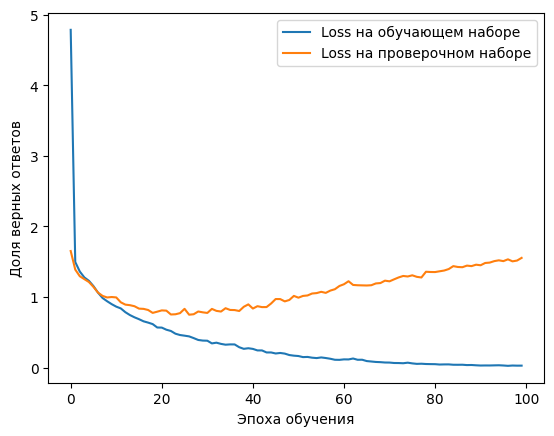

In [ ]:
plt.plot(
    history.history['loss'], label='Loss на обучающем наборе'
)
plt.plot(
    history.history['val_loss'], label='Loss на проверочном наборе'
)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оценка модели

In [ ]:
test_emb  = pd.read_pickle('df_test_true.pkl')

In [ ]:
x_list= test_emb['emb'].to_list()
y_list = test_emb.label.to_list()

In [ ]:
embs, labels_y = together(test_emb)

In [ ]:
embs=[]
labels_y=[]
for i in range(len(x_list)):
    x_train = np.full((3072), -99.)
    y_train = np.zeros((1))

    if len(x_list[i])==1:
      x_train[0:768] = x_list[i][0]
      y_train = y_list[i]

    if len(x_list[i])==2:
      x_train[0:1536] = x_list[i].reshape(1, 1536)
      y_train = y_list[i]

    if len(x_list[i])==3:
      x_train[0:2304] = x_list[i].reshape(1, 2304)
      y_train = y_list[i]

    if len(x_list[i])==4:
      x_train[0:3072] = x_list[i].reshape(1, 3072)
      y_train = y_list[i]

    embs.append(x_train)
    labels_y.append(y_train)

In [ ]:
embs = np.asarray(embs)

In [ ]:
labels = np.asarray(labels_y)

In [ ]:
emb_new = np.expand_dims(embs_test, 1)

Создаем маску для тестового набора данных

In [ ]:
import torch
import torch.nn as nn

bert_embeddings = torch.tensor(emb_new)
ignore_value_mask = (bert_embeddings != -99.)

masked_bert_embeddings_test = bert_embeddings * ignore_value_mask.float()

In [ ]:
masked_bert_embeddings_test = np.asarray(masked_bert_embeddings_test)

In [ ]:
y_pred = model.predict(masked_bert_embeddings_test, batch_size=1000, verbose=1)
y_pred_b = np.argmax(y_pred, axis=1)

4/4 [==============================] - 2s 21ms/step


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#print(classification_report(y_test, y_pred_b))
report = classification_report(
    labels_y_test,
    y_pred_b,

)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       653
           1       0.86      0.83      0.84       345
           2       0.71      0.65      0.68       137
           3       0.89      0.89      0.89       288
           4       0.75      0.74      0.74       193
           5       0.91      0.93      0.92       148
           6       0.84      0.81      0.82      1231
           7       0.91      0.85      0.88       136
           8       0.71      0.65      0.68       354
           9       0.76      0.85      0.80       310

    accuracy                           0.81      3795
   macro avg       0.81      0.80      0.81      3795
weighted avg       0.81      0.81      0.81      3795

